In [ ]:
import sys
import setuptools._distutils as distutils
sys.modules["distutils"] = distutils

from imutils import paths
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os


In [ ]:
# Parameters
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
IMAGE_DIMS = (224, 224)

dataset_dir = "C:/Users/Souma Chakraborty/OneDrive/Desktop/ML_RESEARCH/Fruit And Vegetable Diseases Dataset"
# Allowed classes are just the folder names
ALLOWED_CLASSES = {"Apple__Healthy", "Apple__Rotten"}

data = []
labels = []

# Get image paths from the dataset directory
imagePaths = list(paths.list_images(dataset_dir))
print(f"Found {len(imagePaths)} images in total.")

# Debug: Print first few paths to verify structure
print("Sample image paths:")
for path in imagePaths[:5]:
    print(path)

# Process each image path
for imagePath in imagePaths:
    # Extract the class label from the parent folder name
    label = imagePath.split(os.path.sep)[-2]
    print(f"Processing: {imagePath}, Label: {label}")  # Debug print
    
    if label not in ALLOWED_CLASSES:
        print(f"Skipping {label} - not in allowed classes")  # Debug print
        continue

    # Load the image, resize, and convert to array
    image = cv2.imread(imagePath)
    if image is None:
        print(f"Failed to load image: {imagePath}")  # Debug print
        continue
        
    image = cv2.resize(image, IMAGE_DIMS)
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(label)

print(f"\nProcessed {len(data)} images")
print(f"Unique labels found: {set(labels)}")

if len(data) == 0:
    raise ValueError("No images were processed. Check your dataset directory and paths.")

data = np.array(data, dtype="float32")
labels = np.array(labels)


Found 29276 images in total.
Sample image paths:
C:/Users/Souma Chakraborty/OneDrive/Desktop/ML_RESEARCH/Fruit And Vegetable Diseases Dataset\Apple_healthy_augmented\rotated_by_15_Screen Shot 2018-06-08 at 4.59.36 PM.png
C:/Users/Souma Chakraborty/OneDrive/Desktop/ML_RESEARCH/Fruit And Vegetable Diseases Dataset\Apple_healthy_augmented\rotated_by_15_Screen Shot 2018-06-08 at 4.59.44 PM.png
C:/Users/Souma Chakraborty/OneDrive/Desktop/ML_RESEARCH/Fruit And Vegetable Diseases Dataset\Apple_healthy_augmented\rotated_by_15_Screen Shot 2018-06-08 at 4.59.57 PM.png
C:/Users/Souma Chakraborty/OneDrive/Desktop/ML_RESEARCH/Fruit And Vegetable Diseases Dataset\Apple_healthy_augmented\rotated_by_15_Screen Shot 2018-06-08 at 5.00.03 PM.png
C:/Users/Souma Chakraborty/OneDrive/Desktop/ML_RESEARCH/Fruit And Vegetable Diseases Dataset\Apple_healthy_augmented\rotated_by_15_Screen Shot 2018-06-08 at 5.00.12 PM.png
Processing: C:/Users/Souma Chakraborty/OneDrive/Desktop/ML_RESEARCH/Fruit And Vegetable Dis

In [36]:
# Cell 3: Build the model with MobileNetV2
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

if len(lb.classes_) == 2:
    labels = np.hstack((labels, 1 - labels))

# Split into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=42)
# Load the base MobileNetV2 model without the top layers
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(IMAGE_DIMS[0], IMAGE_DIMS[1], 3)))

# Construct the head of the model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)

# Combine base and head into a single model
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze the base model layers so only the head is trained initially
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


C:\Users\Souma Chakraborty\AppData\Local\Temp\ipykernel_16660\1334659766.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,
c:\Users\Souma Chakraborty\OneDrive\Desktop\ML_RESEARCH\resenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [37]:
# Cell 4: Train the model
print("[INFO] Training model...")
H = model.fit(trainX, trainY, batch_size=BS, validation_data=(testX, testY), epochs=EPOCHS)


[INFO] Training model...
Epoch 1/20


c:\Users\Souma Chakraborty\OneDrive\Desktop\ML_RESEARCH\resenv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_475']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 405ms/step - accuracy: 0.6223 - loss: 0.7102 - val_accuracy: 0.8221 - val_loss: 0.3444
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 381ms/step - accuracy: 0.8276 - loss: 0.3741 - val_accuracy: 0.8829 - val_loss: 0.2605
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - accuracy: 0.8950 - loss: 0.2499 - val_accuracy: 0.9099 - val_loss: 0.2192
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 385ms/step - accuracy: 0.9134 - loss: 0.2071 - val_accuracy: 0.9257 - val_loss: 0.1932
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 387ms/step - accuracy: 0.9456 - loss: 0.1561 - val_accuracy: 0.9324 - val_loss: 0.1671
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 394ms/step - accuracy: 0.9455 - loss: 0.1505 - val_accuracy: 0.9414 - val_loss: 0.1488
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 424ms/step - accuracy: 0.9524 - loss: 0.1353 - val_accuracy: 0.9459 - val_loss: 0.1399
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 399ms/step - accuracy: 0.9631 - loss: 0.1104 - val_accuracy: 0.955

In [38]:
# Cell 5: Evaluate the model and save results

print("[INFO] Evaluating model...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = predIdxs.argmax(axis=1)
trueIdxs = testY.argmax(axis=1)

print(classification_report(trueIdxs, predIdxs, target_names=lb.classes_))

# Save the model to disk
model.save("apple_classifier_mobilenetv2.h5")


[INFO] Evaluating model...


c:\Users\Souma Chakraborty\OneDrive\Desktop\ML_RESEARCH\resenv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_475']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step


                precision    recall  f1-score   support

Apple__Healthy       0.99      0.97      0.98       219
 Apple__Rotten       0.97      0.99      0.98       225

      accuracy                           0.98       444
     macro avg       0.98      0.98      0.98       444
  weighted avg       0.98      0.98      0.98       444



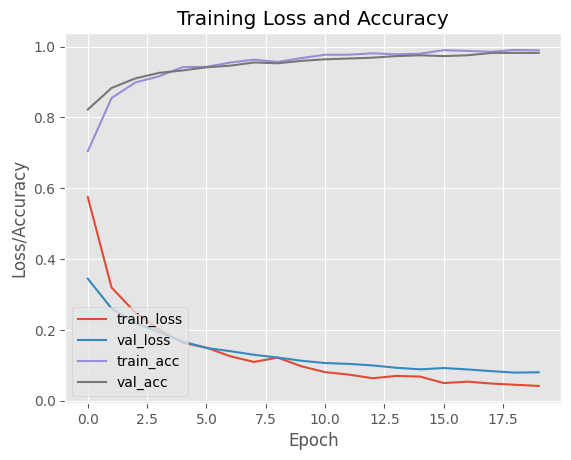

In [39]:
# Cell 6: Plot training loss and accuracy

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()


In [40]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(testX, testY, batch_size=BS)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - accuracy: 0.9809 - loss: 0.0783
Test Loss: 0.08014565706253052
Test Accuracy: 0.9819819927215576
